In [1]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import cm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler
from tree_utils import *
import pandas as pd
import joblib


In [2]:
df = pd.read_csv("/Users/carolbarroco/Documents/RecomendSisKNN/TG2 RecommendSys/GitHub/T2-Indroducao-Ciencia-de-Dados/Data/MPBROCKMETAL_KGDataSet.csv")
scaler = joblib.load("scaler.pkl")
label_encoder = joblib.load("label_encoder.pkl") 
best_tree = joblib.load("/Users/carolbarroco/Documents/RecomendSisKNN/TG2 RecommendSys/GitHub/T2-Indroducao-Ciencia-de-Dados/Modeling/best_tree.pkl")


# Set max rows and columns to display
pd.set_option('display.max_rows', 200)     # or any large number you want
pd.set_option('display.max_columns', None) # show all columns


In [3]:
del df["Unnamed: 0"]
del df["Unnamed: 0.1"]

In [4]:

def pDecisionTree(Xdata, ydata):
    feature_names = Xdata.columns

    # Scale new data
    X_new_scaled = scaler.transform(Xdata)
    X_new = pd.DataFrame(X_new_scaled, columns=feature_names)
    y_true_encoded = label_encoder.transform(ydata)
    class_labels = label_encoder.classes_

    # Predict using the already-trained best_tree
    tree_pred = best_tree.predict(X_new)


    return X_new,tree_pred, y_true_encoded, class_labels  # Return both to allow accuracy calculation

def getAccuracy(y_pred, y_true_encoded, class_labels):
    acc = accuracy_score(y_true_encoded, y_pred)
    print(f"Accuracy: {acc:.4f}")
    cm = confusion_matrix(y_true_encoded, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
    disp.plot(xticks_rotation=45, cmap='Blues')
    

def add_encoded_labels_to_df(y_true_encoded, df):
    df_y_encoded = pd.DataFrame({"track_genre_encoded": y_true_encoded})
    df_combined = pd.merge(df, df_y_encoded, left_index=True, right_index=True)
    return df_combined

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9730


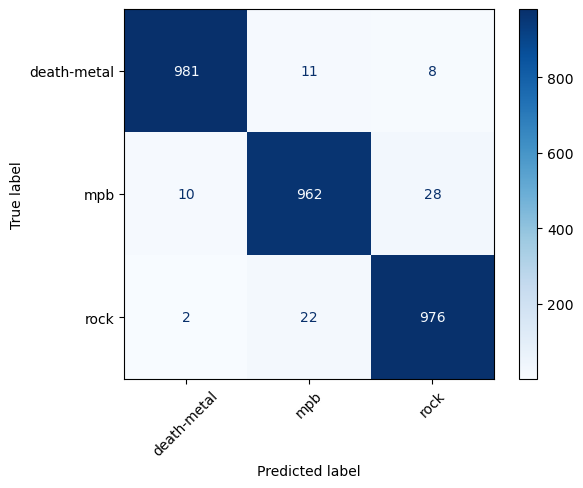

In [5]:
Xs = df.iloc[:, 4:18]
y = df["track_genre"]

t, x, y,z= pDecisionTree(Xs,y)
df_encoded_genr = add_encoded_labels_to_df(y, df)
getAccuracy(x,y,z)

In [6]:
df_with_leaf_nodes =  get_samples_leaf_nodes(best_tree, t)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [24]:
df_completo = pd.merge(df_with_leaf_nodes,df, left_index=True, right_index=True)
lista_colunas =  ['track_id', 'artists', 'album_name', 'track_name','popularity', 'duration_ms', 'explicit', 'danceability', 'leaf_node',
'energy','key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness','liveness', 'valence', 'tempo', 'time_signature', 'track_genre']
       
df_completo = df_completo[lista_colunas]

df_completo = df_completo.reset_index()

In [28]:
# def getLeafBased2DRecommendations(df, pc_cols=['PC1', 'PC2'],leaf_col='leaf_node'):
#    grouped = df.groupby('leaf_node')
#    leaf_node_groups = {leaf: group for leaf, group in df.groupby('leaf_node')}
#    for key in leaf_node_groups.keys():
#         sorted_group = .sort_values(by=['PC1', 'PC2'], ascending=[True, True])
   
from sklearn.decomposition import PCA


def addPCA(df, feature_start=5, feature_end=19, n_components=2):
    df = df.copy()
    X = df.iloc[:, feature_start:feature_end]
    X_scaled = scaler.fit_transform(X)
    
    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X_scaled)
    
    df['PC1'] = components[:, 0]
    df['PC2'] = components[:, 1]
    
    return df


def getLeafBased2DInfo(df, pc_cols=['PC1', 'PC2'], leaf_col='leaf_node'):
    # Group the dataframe by the leaf node
    grouped = df.groupby(leaf_col)
    
    # Create a dictionary with sorted groups
    leaf_node_groups = {}
    for leaf, group in grouped:
        sorted_group = group.sort_values(by=pc_cols, ascending=[True, True])
        leaf_node_groups[leaf] = sorted_group

    return grouped, leaf_node_groups

        
    
def add_directional_recommendations(df, leaf_node_groups, id_col='index', k=5):
    df = df.copy()
    df['Recommendations'] = None  # prepare column

    for leaf, sorted_leaf_df in leaf_node_groups.items():
        sorted_leaf_df = sorted_leaf_df.reset_index(drop=True)
        leaf_len = len(sorted_leaf_df)

        for idx, row in sorted_leaf_df.iterrows():
            song_id = row[id_col]

            # Determine direction of recommendation
            if idx < leaf_len / 2:
                recs = sorted_leaf_df.iloc[idx + 1:][id_col].tolist()
            else:
                recs = sorted_leaf_df.iloc[:idx][id_col].tolist()

            # Optional: limit number of recommendations
            if k is not None:
                recs = recs[:k]

            # Assign safely to the exact row in the main df
            df.at[df[df[id_col] == song_id].index[0], 'Recommendations'] = recs

    return df

            
        
    
df_completo= addPCA(df_completo)
a,b= getLeafBased2DInfo(df_completo)
directional_recommendations = add_directional_recommendations(df_completo,b)





index                track_id                 artists  \
0         0  6g2BiiVQqY5v1S4HIrM54F        Rodrigo Amarante   
1         1  6Dc2tCivms1s2X9myWe4ni        Rodrigo Amarante   
2         2  76HOOcFt3lKVdScmoScfz1                  Djavan   
3         3  4crctLJMKJekuqQ7cQLpHV  Nicolas Candido;Olívia   
4         4  0XXwP0EmpOEqWxcL9aSreJ               Fábio Jr.   
...     ...                     ...                     ...   
2995   2995  78adEMnfn1XolaOh2QAjZS                Brujeria   
2996   2996  53c9YHuifgAWJoqgPOgPUn               Unleashed   
2997   2997  6us7QqYJGMGZqej8dKCFGC          Bury Your Dead   
2998   2998  5l5XKQmo9M0XHdNAPddq0i                   Surra   
2999   2999  1eUrfmvVOuy7RsS11Kz74Q         Toxic Holocaust   

                                             album_name  \
0     Tuyo (Narcos Theme) [Extended Version] [A Netf...   
1     Tuyo (Narcos Theme) [A Netflix Original Series...   
2                                      Djavan "Ao Vivo"   
3                            Apaga a Luz (feat. Olívia)   
4                                             Fabio Jr.   
...                                                 ...   
2995                                         Brujerizmo   
2996                                Gods of Death Metal   
2997                                  Cover Your Tracks   
2998                                       Bica na Cara   
2999                            An Overdose of Death...   

                                             track_name  popularity  \
0     Tuyo (Narcos Theme) [Extended Version] - A Net...          66   
1     Tuyo (Narcos Theme) - A Netflix Original Serie...          65   
2                                        Azul (Ao Vivo)          49   
3                            Apaga a Luz (feat. Olívia)          49   
4                                      Pareço um Menino          50   
...                                                 ...         ...   
2995                            Laboratorio Cristalitos          20   
2996                          Long Before Winter's Call           0   
2997                                Mission: Impossible          21   
2998                                     Vida de Babaca          22   
2999                       Feedback, Blood & Distortion          22   

      duration_ms  explicit  danceability  leaf_node  energy  key  loudness  \
0          151565     False         0.765        210   0.497    1    -7.806   
1           89293     False         0.720        210   0.422    1   -13.338   
2          259066     False         0.632        163   0.651    7    -8.658   
3          216446     False         0.610        158   0.420    4   -10.889   
4          273906     False         0.580        158   0.330    7   -13.703   
...           ...       ...           ...        ...     ...  ...       ...   
2995        91866     False         0.474        125   0.993    1    -5.850   
2996       227616     False         0.370         21   0.993    7    -4.465   
2997       162973      True         0.307        125   0.976    2    -3.552   
2998       135893      True         0.362        209   0.994    6    -1.722   
2999       206973     False         0.260        125   0.994   10    -5.291   

      speechiness  acousticness  instrumentalness  liveness  valence    tempo  \
0          0.0402      0.492000          0.366000    0.1430   0.4570  112.195   
1          0.0690      0.474000          0.084700    0.1550   0.5460  112.219   
2          0.0401      0.756000          0.000004    0.7260   0.6520  119.567   
3          0.0462      0.815000          0.000000    0.1230   0.5530   96.313   
4          0.0295      0.596000          0.000001    0.0849   0.3730  136.408   
...           ...           ...               ...       ...      ...      ...   
2995       0.1270      0.000432          0.030100    0.3380   0.1550  128.239   
2996       0.1310      0.000078          0.006220    0.1270   0.0398  103.052   
2997     

In [34]:
import plotly.express as px
from sklearn.decomposition import PCA
import pandas as pd

def interactive_pca_plot(df, genre):
    genre_df = df[df["track_genre"] == genre].copy()

    features = genre_df.columns[5:19]  # Adjust if necessary
    X = genre_df[features]

    # === Run PCA ===
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    # === Create DataFrame for plot ===
    pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    pca_df["track_name"] = genre_df["track_name"].values
    pca_df["index"] = genre_df.index
    pca_df["track_genre"] = genre_df["track_genre"].values
    pca_df["origin"] = genre_df.index  # each track is its own origin
    pca_df["leaf_node"] = genre_df["leaf_node"].values
    pca_df["type"] = "original"

    # === Add recommendations ===
    for idx in genre_df.index:
        recommendations = df.loc[idx, "Recommendations"]
        for rec_idx in recommendations:
            rec_row = df.loc[rec_idx]
            rec_features = rec_row[features].values.reshape(1, -1)
            rec_pca = pca.transform(rec_features)
            pca_df = pd.concat([
                pca_df,
                pd.DataFrame([{
                    "PC1": rec_pca[0, 0],
                    "PC2": rec_pca[0, 1],
                    "track_name": rec_row["track_name"],
                    "leaf_node": rec_row["leaf_node"],
                    "index": rec_idx,
                    "track_genre": rec_row["track_genre"],
                    "origin": idx,
                    "type": "recommendation"
                }])
            ], ignore_index=True)

    # === Define colors based on original song ===
    unique_origins = pca_df[pca_df["type"] == "original"]["origin"].unique()
    color_map = {
        idx: px.colors.qualitative.Safe[i % len(px.colors.qualitative.Safe)]
        for i, idx in enumerate(unique_origins)
    }
    pca_df["color"] = pca_df["origin"].map(color_map)

    # === Plot using only points with hover info ===
    fig = px.scatter(
        pca_df,
        x="PC1",
        y="PC2",
        color="color",
        hover_data={
            "track_name": True,
            "index": True,
            "track_genre": True,
            "origin": True,
            "type": True,
            "leaf_node": True,
            "color": False,  # hide actual color code in hove
            "PC1": False,
            "PC2": False
        }
    )
    fig.update_traces(marker=dict(size=8, opacity=0.8), showlegend=False)
    fig.update_layout(title=f"PCA of {genre} Tracks + Recommendations (Hover for details)")
    fig.show()
    return pca_df

interactive_pca_plot(directional_recommendations, "mpb")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWar

PC1        PC2  \
0     -77651.359973  54.966461   
1    -139923.359968  55.951100   
2      29849.639045   2.808395   
3     -12770.360674   3.432146   
4      44689.638699  -5.370984   
...             ...        ...   
5768  -79483.361758  -6.215046   
5769   17796.638967   1.924529   
5770   38516.638929   1.540777   
5771  137156.638768 -13.915135   
5772   84809.639003  -9.551322   

                                             track_name  index track_genre  \
0     Tuyo (Narcos Theme) [Extended Version] - A Net...      0         mpb   
1     Tuyo (Narcos Theme) - A Netflix Original Serie...      1         mpb   
2                                        Azul (Ao Vivo)      2         mpb   
3                            Apaga a Luz (feat. Olívia)      3         mpb   
4                                      Pareço um Menino      4         mpb   
...                                                 ...    ...         ...   
5768                                 Os Anjos - Ao Vivo    690         mpb   
5769                                Envelheço Na Cidade    687         mpb   
5770                                            Timidez    442         mpb   
5771                                   Vento No Litoral    300         mpb   
5772                          Canto de Oxum / Inscrição    151         mpb   

      origin  leaf_node            type               color  
0          0        210        original  rgb(136, 204, 238)  
1          1        210        original  rgb(204, 102, 119)  
2          2        163        original  rgb(221, 204, 119)  
3          3        158        original    rgb(17, 119, 51)  
4          4        158        original    rgb(51, 34, 136)  
...      ...        ...             ...                 ...  
5768     998        165  recommendation    rgb(136, 34, 85)  
5769     998        165  recommendation    rgb(136, 34, 85)  
5770     998        165  recommendation    rgb(136, 34, 85)  
5771     999        149  recommendation     rgb(102, 17, 0)  
5772     999        149  recommendation     rgb(102, 17, 0)  

[5773 rows x 9 columns]

In [36]:
interactive_pca_plot(directional_recommendations, "rock")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature

PC1         PC2               track_name  index track_genre  \
0    -22890.506009   60.048284         Sex, Drugs, Etc.   1000        rock   
1    -35718.490471  154.568390         I Wanna Be Yours   1001        rock   
2     20725.507112  144.879071          Sweater Weather   1002        rock   
3    -71189.492034  159.566707          I Ain't Worried   1003        rock   
4     67898.504821  128.055217  Nasha (Equals Sessions)   1004        rock   
...            ...         ...                      ...    ...         ...   
5845 -26354.521050  -37.169619   Bigmouth Strikes Again   1397        rock   
5846  30951.478514  -46.300144       Livin' On A Prayer   1290        rock   
5847  30951.478590  -45.875480       Livin' On A Prayer   1287        rock   
5848  30951.478667  -45.450817       Livin' On A Prayer   1295        rock   
5849 -12608.520753  -39.171010       Hell Or High Water   1379        rock   

      origin  leaf_node            type               color  
0       1000        111        original  rgb(136, 204, 238)  
1       1001        210        original  rgb(204, 102, 119)  
2       1002        210        original  rgb(221, 204, 119)  
3       1003        210        original    rgb(17, 119, 51)  
4       1004        210        original    rgb(51, 34, 136)  
...      ...        ...             ...                 ...  
5845    1999         44  recommendation     rgb(102, 17, 0)  
5846    1999         44  recommendation     rgb(102, 17, 0)  
5847    1999         44  recommendation     rgb(102, 17, 0)  
5848    1999         44  recommendation     rgb(102, 17, 0)  
5849    1999         44  recommendation     rgb(102, 17, 0)  

[5850 rows x 9 columns]

In [38]:
interactive_pca_plot(directional_recommendations, "death-metal")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names

/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning:

X does not have valid feature names, but PCA was fitted with feature

PC1        PC2             track_name  index  track_genre  \
0      23924.295539 -25.043569        Our Time Is Now   2000  death-metal   
1     183240.295373  -6.545882   Hallowed Be Thy Name   2001  death-metal   
2     -38972.704259  10.370782     Soldier of Fortune   2002  death-metal   
3     -54932.704377  -4.042298     You Only Live Once   2003  death-metal   
4     -23559.704666 -44.907490      Voice of the Soul   2004  death-metal   
...             ...        ...                    ...    ...          ...   
5880    -852.705206   0.725711              Svartberg   2669  death-metal   
5881  -73919.705233 -14.761050    Beneath Dying Skies   2394  death-metal   
5882 -119666.704992  42.498981                Mkultra   2733  death-metal   
5883   10240.295422 -36.417355       L'enfant sauvage   2070  death-metal   
5884  -27292.705285 -19.026190  Rid You of Your Flesh   2559  death-metal   

      origin  leaf_node            type               color  
0       2000        133        original  rgb(136, 204, 238)  
1       2001        133        original  rgb(204, 102, 119)  
2       2002        186        original  rgb(221, 204, 119)  
3       2003        125        original    rgb(17, 119, 51)  
4       2004        109        original    rgb(51, 34, 136)  
...      ...        ...             ...                 ...  
5880    2999        125  recommendation     rgb(102, 17, 0)  
5881    2999        125  recommendation     rgb(102, 17, 0)  
5882    2999        125  recommendation     rgb(102, 17, 0)  
5883    2999        125  recommendation     rgb(102, 17, 0)  
5884    2999        125  recommendation     rgb(102, 17, 0)  

[5885 rows x 9 columns]